<a href="https://colab.research.google.com/github/PhilBurub/ML_course_MSc/blob/main/HW2_recsys/HSE_RecSys_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ДЗ №2. Матричные факторизации

#### В этой домашке вам предстоит реализовать некоторые базовые модели матричной факторизации

#### Дата выдачи: 17.02.25

#### Мягкий дедлайн: 02.03.25 23:59 MSK

#### Жесткий дедлайн: 09.03.25 23:59 MSK

В этом задании мы будем работать с классическим для рекоендательных систем датасетом [MovieLens 1M](https://grouplens.org/datasets/movielens/1m/). Датасет содержит рейтинги оценки для 4000 фильмов от 6000 пользователей. Более подробное описание можете найти на странице с датасетом и в README файле

In [108]:
!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip
!cat ml-1m/README

--2025-03-01 12:05:09--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip.1’

ml-1m.zip.1         100%[===================>]   5.64M  25.1MB/s    in 0.2s    

2025-03-01 12:05:09 (25.1 MB/s) - ‘ml-1m.zip.1’ saved [5917549/5917549]

Archive:  ml-1m.zip
replace ml-1m/movies.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: SUMMARY

These files contain 1,000,209 anonymous ratings of approximately 3,900 movies 
made by 6,040 MovieLens users who joined MovieLens in 2000.

USAGE LICENSE

Neither the University of Minnesota nor any of the researchers
involved can guarantee the correctness of the data, its suitability
for any particular purpose, or the validity of results based on the
use of the data set.  The data set may be u

In [109]:
import pandas as pd
import numpy as np
from typing import Union

In [110]:
df = pd.read_csv("ml-1m/ratings.dat", sep='::', names=['user_id', 'item_id', 'rating', 'timestamp'], engine='python')
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df.drop('timestamp', axis=1, inplace=True)
df.head()

,user_id,item_id,rating,datetime
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


In [111]:
value_counts = df['item_id'].value_counts()
filtered_values = value_counts[value_counts > 20].index
df = df[df['item_id'].isin(filtered_values)].copy()

In [112]:
train_end = '2000-12-01'
df_train = df[df['datetime'] < train_end].copy()
df_test = df[df['datetime'] >= train_end].copy()
df_train.shape, df_test.shape

((787420, 4), (207432, 4))

In [113]:
train_users = df_train['user_id'].unique()
train_items = df_train['item_id'].unique()

df_test = df_test[df_test['user_id'].isin(train_users)]
df_test = df_test[df_test['item_id'].isin(train_items)]
df_test.shape

(106471, 4)

In [114]:
from sklearn.preprocessing import LabelEncoder

user_le = LabelEncoder()
item_le = LabelEncoder()

df_train['user_id'] = user_le.fit_transform(df_train['user_id'])
df_train['item_id'] = item_le.fit_transform(df_train['item_id'])

df_test['user_id'] = user_le.transform(df_test['user_id'])
df_test['item_id'] = item_le.transform(df_test['item_id'])

In [115]:
df_train['user_id'].nunique(), df_train['user_id'].max()
df_train['item_id'].nunique(), df_train['item_id'].max()

(3010, 3009)

##### Задание 1. Напишем функцию, которая превратит датафрейм в матрицу интеракций. В функции df_to_matrix реализуйте функцию, которая принимает датафрейм и возвращает np.array матрицу интеракций. В функции df_to_coo реализуйте функцию, которая принимает датафрейм и возвращает разреженную матрицу интеракций в coo_array формате

In [116]:
def df_to_matrix(df: pd.DataFrame) -> np.ndarray:
    result = np.zeros((
        df.user_id.nunique(),
        df.item_id.nunique()
    ))
    result[
        df.user_id.values,
        df.item_id.values
    ] = df.rating.values
    return result #shape ~ [n_users, n_items]

In [117]:
interactions = df_to_matrix(df_train)

In [118]:
from scipy.sparse import coo_array

def df_to_coo(df: pd.DataFrame) -> coo_array:
    shape = (
        df_train.user_id.nunique(),
        df_train.item_id.nunique()
    )
    coords = df_train[['user_id', 'item_id']].T.values

    result = coo_array((df_train.rating.values, coords), shape=shape, dtype=float)
    return result # coo_array

In [119]:
coo_interactions = df_to_coo(df_train)

In [120]:
assert (interactions != 0).sum() == df_train.shape[0]
assert interactions[0, 2994] == 3
assert interactions[2369, 1203] == 5
assert interactions[1557, 459] == 3
assert np.allclose(coo_interactions.toarray(), interactions)

##### Задание 2.1. Рассмотрим [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition). Возьмите готовую реализуцию алгоритма из numpy.linalg или из scipy.linalg и примените алгоритм к матрицам интеракций, полученным в первом задании. Для работы со sparse матрицей обычная реализация svd не подойдет и нужно будет воспользоваться scipy.sparse.linalg.svds. Вам нужно разложить матрицу интеракций на 3 матрицы U, S, V, а затем перемножить их и восстановить изначальную матрицу. При полном разложении исходная матрица должна восстанавливаться максимально хорошо

In [121]:
from scipy.linalg import svd
from scipy.sparse.linalg import svds

In [122]:
def make_svd(interractions: Union[np.ndarray, coo_array], n_singular_values: int = -1):
    # функция должна работать и для полной матрицы и для sparse матрицы(вам поможет isinstance).
    # если n_singular_values = -1, то берем все сингулярные числа для полной матрицы
    # и все кроме одного сингулярного числа для coo-матрицы(иначе scipy.sparse.linalg.svds не будет работать)
    if isinstance(interractions, np.ndarray):
        U, S_flat, V = svd(interactions)
        if n_singular_values != -1:
            idxs = S_flat.argsort()[-n_singular_values:]
            U = U[:, idxs]
            S_flat = S_flat[idxs]
            V = V[idxs, :]

    elif isinstance(interractions, coo_array):
        U, S_flat, V = svds(
            interractions,
            k=min(*interractions.shape)-1 if n_singular_values==-1 else n_singular_values
        )

    S = np.zeros((U.shape[1], V.shape[0]))
    filled_idxs = np.arange(S_flat.shape[0])
    S[filled_idxs, filled_idxs] = S_flat

    return U, S, V

In [123]:
U, S, V = make_svd(interactions)
assert np.allclose(U @ S @ V, interactions)

In [124]:
U1, S1, V1 = make_svd(interactions, 10)
U, S, V = make_svd(coo_interactions, 10)
assert np.allclose(U1 @ S1 @ V1, U @ S @ V)

##### Задание 2.2. Теперь попробуем сделать рекомендации с помощью SVD. Мы научились восстанавливать исходную матрицу с помощью разложения, теперь же мы хотим порекомендовать пользователю айтемы, которые будут для него максимально релевантны(в восстановленной матрице у них будет самый высокий скор). Для каждого пользователя нужно будет найти индексы айтемов, которые имеют максимальный скор. При этом стоит обратить внимание, что мы не хотим рекомендовать пользователю айтемы, с которыми он уже взаимодействовал

In [125]:
def make_svd_recommendations(interractions: Union[np.ndarray, coo_array], n_singular_values: int = -1, top_k: int = 100):
    # Возвращает матрицу вида n_users, top_k, то есть для каждого пользователя возвращаем индексы
    # top_k самых релевантный айтемов среди тех с которыми он еще не взаимодействовал

    U, S, V = make_svd(interractions, n_singular_values)
    new_matrix = U @ S @ V
    recommendations_matrix = np.where(
        interractions==0 if isinstance(interractions, np.ndarray) else interractions.toarray()==0,
        new_matrix,
        -float('inf')
    )

    num_items = interractions.shape[1]
    recommendations = recommendations_matrix.argsort()[:, :num_items-top_k-1:-1]

    return recommendations #shape ~ [n_users, top_k]

In [126]:
recs = make_svd_recommendations(interactions, -1, 100)
assert recs.shape == (interactions.shape[0], 100)

##### Задание 2.3. Теперь давайте посмотрим как будет зависеть качетво рекомендаций, от количества сингулярных чисел, которые мы возьмем в SVD разложении. Переберите n_singular_values из списка [1, 10, 50, 200, 1000] и посмотрите как будет изменяться метрика NDCG на тестовом датасете для таких рекомендаций и как будет меняться время вычисления. Для каждого графики зависимости метрики NDCG от n_singular_values и времени работы алгоритма от n_singular_values(Время работы будет меняться только для sparse-матрицы, стоит запускать алгоритм именно для нее)

In [127]:
import time
from sklearn.metrics import ndcg_score
from matplotlib import pyplot as plt

In [128]:
def ndcg(gt_scores, pred_items):
    num_users = gt_scores.shape[0]
    num_items = gt_scores.shape[1]
    top_k = pred_items.shape[1]

    k_rel_scores = gt_scores[
        np.expand_dims(np.arange(num_users), axis=-1),
        pred_items
    ]
    penalty = np.log2(np.arange(top_k) + 2)
    dcg = (k_rel_scores / penalty).sum(axis=1)


    best_pred = gt_scores.argsort()[:, :num_items-top_k-1:-1]
    max_rel_scores = gt_scores[
        np.expand_dims(np.arange(num_users), axis=-1),
        best_pred
    ]
    idcg = (max_rel_scores / penalty).sum(axis=1)

    return np.where(idcg>0, np.divide(dcg, idcg, where=idcg>0), 0)

In [129]:
gt_scores = np.zeros(interactions.shape)
gt_scores[
    df_test.user_id.values,
    df_test.item_id.values
] = df_test.rating.values

In [130]:
def plot_graphs(interractions: Union[np.ndarray, coo_array], top_k: int = 100):
    values = []
    time_s = []
    metric = []
    for n_singular_values in [1, 10, 50, 200, 1000]:
        values.append(n_singular_values)

        start = time.time()
        recs = make_svd_recommendations(interractions, n_singular_values=n_singular_values, top_k=top_k)
        time_s.append(time.time() - start)

        metric.append(ndcg(gt_scores, recs).mean())

    fig, (timeplot, metric_plot) = plt.subplots(2, 1, sharex=True)
    timeplot.plot(values, time_s)
    timeplot.set_ylabel('duration, s')
    timeplot.set_title('Learn and Prediction Duration by n_singular_values')

    metric_plot.plot(values, metric)
    metric_plot.set_ylabel('metric value')
    metric_plot.set_title('NDCG Value by n_singular_values')
    metric_plot.set_xlabel('n_singular_values')
    fig.show()

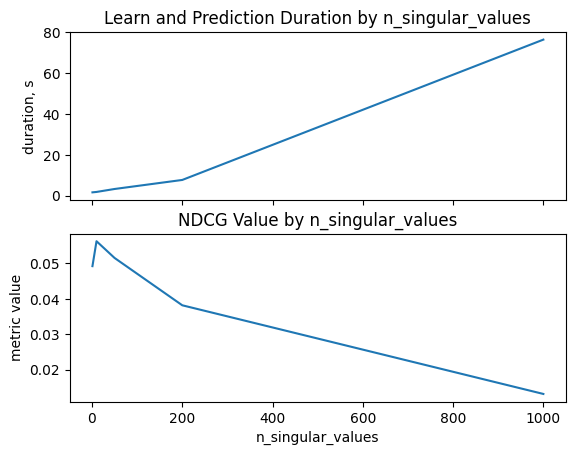

In [131]:
plot_graphs(coo_interactions)

##### Задание 3.1. Перейдем к [ALS](http://yifanhu.net/PUB/cf.pdf). Возьмем реализацию iALS из библиотеки [implicit](https://benfred.github.io/implicit/api/models/cpu/als.html). Обучите ALS на нашем датасете, сделайте top_k рекомендации для юзеров из тестового датасета, и сравните метрики ALS с метриками, которые получились в SVD. Попробуйте перебрать гиперпараметры и найдите оптимальное число факторов, коэффициент alpha и коэффициент регуляризации.

In [132]:
%%capture
!pip install implicit
!export OPENBLAS_NUM_THREADS=1

In [133]:
from implicit.cpu.als import AlternatingLeastSquares
from scipy.sparse import csr_matrix

In [134]:
def make_als_recommendations(
    interractions: Union[np.ndarray, coo_array],
    top_k: int = 100,
    n_factors: int = 100,
    alpha: float = 1.0,
    regularization: float = 0.01,
):
    csr_interations = csr_matrix(interactions)

    als = AlternatingLeastSquares(
        factors=n_factors,
        regularization=regularization,
        alpha=alpha
    )

    als.fit(
        csr_interations,
        show_progress=False
    )
    recommendations = als.recommend(
        np.arange(csr_interations.shape[0]),
        csr_interations,
        N=top_k
    )[0]
    return recommendations, als #shape ~ [n_users, top_k]

In [135]:
recs, als = make_als_recommendations(interactions)
assert recs.shape == (interactions.shape[0], 100)

In [136]:
%%capture
!pip install optuna

In [137]:
import optuna

def als_study(trial):
    n_factors = trial.suggest_int('n_factors', low=1, high=200, step=5)
    alpha = trial.suggest_float('alpha', low=1, high=100, log=True)
    regularization = trial.suggest_float('regularization', low=1e-5, high=2, log=True)
    recs, _ = make_als_recommendations(
        interactions,
        n_factors=n_factors,
        alpha=alpha,
        regularization=regularization
    )
    return ndcg(gt_scores, recs).mean()

study = optuna.create_study(direction='maximize')
study.optimize(als_study, n_trials=40)

[I 2025-03-01 12:16:28,166] A new study created in memory with name: no-name-0aa1935f-7ea7-46cf-a80b-2ed44541f2b2
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [1, 200] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 196].
  warnings.warn(
[I 2025-03-01 12:16:51,487] Trial 0 finished with value: 0.04134530129722354 and parameters: {'n_factors': 141, 'alpha': 4.9948426555796335, 'regularization': 0.11009257047576312}. Best is trial 0 with value: 0.04134530129722354.
[I 2025-03-01 12:17:07,062] Trial 1 finished with value: 0.04053427264816247 and parameters: {'n_factors': 136, 'alpha': 7.096680418900916, 'regularization': 0.010802250904201895}. Best is trial 0 with value: 0.04134530129722354.
[I 2025-03-01 12:17:17,029] Trial 2 finished with value: 0.040377844606108736 and parameters: {'n_factors': 21, 'alpha': 27.329292026688947, 'regularization': 0.03646840637530685}. Best is trial 0 w

In [138]:
study.best_params

{'n_factors': 6,
 'alpha': 1.1272085232152687,
 'regularization': 0.343136613757127}

##### Задание 3.2. Сделайте объяснение рекомендаций для нескольких юзеров(als.explain). Воспользуйтесь файлом movies.dat чтобы перейти от индексов фильмов к их названием

In [139]:
movies = pd.read_csv("ml-1m/movies.dat", sep='::', names=['id', 'name', 'genre'], engine='python', encoding='Windows-1250', index_col=0)
id2movie = movies.name.to_dict()

In [140]:
best_params = study.best_params
best_params['factors'] = best_params.pop('n_factors')

In [141]:
als = AlternatingLeastSquares(**best_params)

als.fit(
    csr_matrix(interactions),
    show_progress=False
)

In [142]:
np.random.seed(42)
csr_interations = csr_matrix(interactions)
recommendations = {}

for uid in np.random.choice(csr_interations.shape[0], 3):
    recommendations[uid] = {}
    for item in recs[uid][:3]:
        explained_by = [
            movie[0] for movie in
            als.explain(
                uid,
                csr_interations,
                item,
                N=3
            )[1]
        ]

        item_name = id2movie[item_le.inverse_transform([item])[0]]
        recommendations[uid][item_name] = [id2movie[movie] for movie in item_le.inverse_transform(explained_by)]

In [143]:
import json

print(
    json.dumps(
        list(recommendations.values()),
        indent='\t',
        ensure_ascii=False
    )
)

[
	{
		"Wag the Dog (1997)": [
			"League of Their Own, A (1992)",
			"Dave (1993)",
			"Full Monty, The (1997)"
		],
		"Babe (1995)": [
			"American Beauty (1999)",
			"Groundhog Day (1993)",
			"Toy Story (1995)"
		],
		"Grosse Pointe Blank (1997)": [
			"American Beauty (1999)",
			"Groundhog Day (1993)",
			"Bug's Life, A (1998)"
		]
	},
	{
		"Shadowlands (1993)": [
			"Remains of the Day, The (1993)",
			"English Patient, The (1996)",
			"Sense and Sensibility (1995)"
		],
		"Sixth Sense, The (1999)": [
			"Schindler's List (1993)",
			"Saving Private Ryan (1998)",
			"Silence of the Lambs, The (1991)"
		],
		"Shawshank Redemption, The (1994)": [
			"Schindler's List (1993)",
			"Saving Private Ryan (1998)",
			"Silence of the Lambs, The (1991)"
		]
	},
	{
		"Austin Powers: The Spy Who Shagged Me (1999)": [
			"American Beauty (1999)",
			"Clerks (1994)",
			"Blair Witch Project, The (1999)"
		],
		"American Pie (1999)": [
			"American Beauty (1999)",
			"Clerks (1994)",
			"Blair

##### Задание 4. До этого мы работали с рейтингами, но как обсуждалось на лекции, implicit ALS отлично работает и с implicit фидбэком. Давайте попробуем преобразовать наш датасет(трейн и тест) следующим образом

1. Бинаризуем все рейтинги(заменим любую интеракцию пользователя на 1)
2. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на 0
3. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1
4. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1 и добавим сглаживание по времени. То есть чем дальше была интеракция от максимальной даты трейна, тем с меньшим весом мы будем ее учитывать(например можно интеракции за последний месяц брать в исходном виде, и с каждым месяцем в прошлое умножать их на какой-нибудь коэффициент меньший 1). Таким образом более старые интеракции пользователя будут вносить меньший вклад в его интересы
5. Придумайте свой вариант(опционально)

Для каждой полученной матрицы обучите iALS и SVD и сравните их результаты между собой(преобразовывать нужно только обучающую выборку, тестовую оставляем неизменной)

In [144]:
df_train['month'] = df_train.datetime.apply(lambda x: x.month + (x.year * 12))
df_train['coef'] = (df_train.month.max() + 1) - df_train.month

In [145]:
coef_matrix = np.ones(interactions.shape)
coef_matrix[
    df_train.user_id.values,
    df_train.item_id.values
] = df_train.coef.values

In [146]:
experiments = {
    '1/0 (>0/=0)': np.where(interactions>0, 1, 0),
    '1/0 (>3/<4)': np.where(interactions>3, 1, 0),
    '1/0/-1 (>3/=0/<4)': np.where(interactions>=4, 1, np.where(interactions==0, 0, -1)),
    '1/0/-1 (>3/=0/<4) w smoothing': np.where(interactions>=4, 1, np.where(interactions==0, 0, -1)) / coef_matrix
}

In [148]:
res = {
    'iALS': {},
    'SVD': {}
}

for exp_name, train_matrix in experiments.items():
    svd_recs = make_svd_recommendations(train_matrix, n_singular_values=5, top_k=100)
    als_recs, _ = make_als_recommendations(train_matrix, top_k=100, **study.best_params)

    res['iALS'][exp_name] = ndcg(gt_scores, als_recs).mean()
    res['SVD'][exp_name] = ndcg(gt_scores, svd_recs).mean()

In [149]:
pd.DataFrame(res)

,iALS,SVD
1/0 (>0/=0),0.055539,0.055711
1/0 (>3/<4),0.055560,0.046787
1/0/-1 (>3/=0/<4),0.055541,0.055711
1/0/-1 (>3/=0/<4) w smoothing,0.055964,0.055711


##### Задание 5. iALS на numpy/torch. Давайте реализуем алгоритм iALS на нумпае или торче. Требуется реализовать алгорит, описанный в 4 части [статьи](http://yifanhu.net/PUB/cf.pdf). Обратите внимания на все оптимизации, которые они описывают в статье, чтобы сократить лишние вычисления. Hint: метрики у вашего алгоритма должны быть сравнимы с метриками ALS из библиотеки implicit

In [ ]:
class iALS:
    def __init__(self, n_factors: int = 100, alpha: float = 1.0, reg_coef = 0.01):
        self.n_factors = n_factors
        self.alpha = alpha
        self.reg_coef = reg_coef

    def fit(self, interractions: np.ndarray, n_iterations: int 10):
        #your code here

    def predict(self, top_k: int = 100):
        # возвращает top-k айтемов для каждого юзера(айтемы с которыми юзер взаимодействовал не должны попасть в рекомендации)
        #your code here

        return predicts # shape ~ [n_users, top_k]